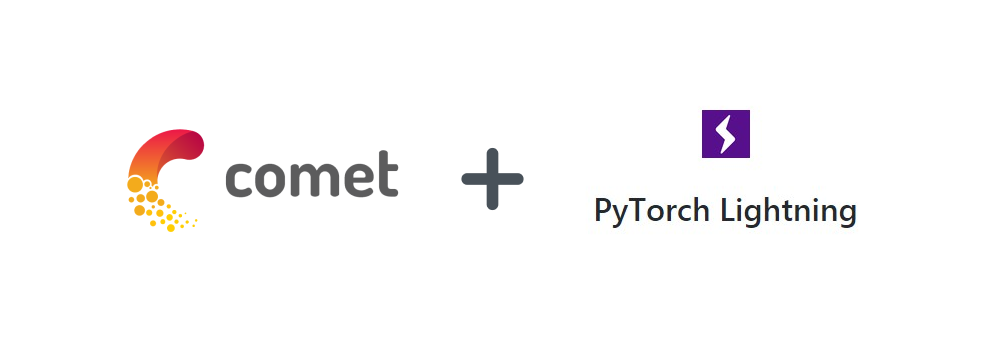![]()

[PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/) helps organize PyTorch code and decouple the science code from the engineering code. It’s more of a style-guide than a framework. By organizing PyTorch code under a LightningModule, Lightning makes things like TPU, multi-GPU and 16-bit precision training (40+ other features) trivial.

The Pytorch Lightning `CometLogger` allows you to easily track your model hyperparameters, metrics, assets and much more! You can find more information about this integration [here](https://www.comet.ml/docs/v2/integrations/ml-frameworks/pytorch-lightning/)

Curious about how Comet can help you build better models, faster? Find out more about [Comet](https://www.comet.ml/site) and our [other integrations](https://www.comet.ml/docs/v2/integrations/overview/)

# Install Comet

In [ ]:
!pip install comet_ml --quiet

# Install Dependencies

In [ ]:
!pip install torch --quiet
!pip install torchvision --quiet
!pip install pytorch-lightning --quiet

# Initialize Comet

In [ ]:
import comet_ml
comet_ml.init(project_name='comet-examples-pytorch-lightning')

# Create the `CometLogger`

In [ ]:
import os
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CometLogger

# arguments made to CometLogger are passed on to the comet_ml.Experiment class
comet_logger = CometLogger()

# Define Lightning Template

In [ ]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader


class Model(pl.LightningModule):
    def __init__(self, layer_size=784):
        super().__init__()
        self.save_hyperparameters()
        self.l1 = torch.nn.Linear(layer_size, 10)

    def forward(self, x):
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        self.logger.log_metrics({'train_loss': loss}, step=batch_nb)  
        return loss

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.logger.log_metrics({'val_loss': loss}, step=batch_nb)
        return loss
      
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

# Define Training Parameters

In [ ]:
import os
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64

# Run Training

In [ ]:
# Init our model
model = Model()

# Init DataLoader from MNIST Dataset
train_ds = MNIST(PATH_DATASETS, train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)

eval_ds = MNIST(PATH_DATASETS, train=False, download=True, transform=transforms.ToTensor())
eval_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)

comet_logger.log_hyperparams({"batch_size": BATCH_SIZE})

# Initialize a trainer
trainer = Trainer(
    gpus=AVAIL_GPUS,
    max_epochs=3,
    logger=comet_logger
)

# Train the model ⚡
trainer.fit(model, train_loader, eval_loader)